<a href="https://colab.research.google.com/github/abhisheksuran/myGAN-tf2.0/blob/master/mnistConditionalGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_labels = tf.one_hot(train_labels, depth=10)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data
#image_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE)
#label_dataset = tf.data.Dataset.from_tensor_slices(train_labels).batch(BATCH_SIZE)

In [ ]:
train_labels[1]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [ ]:
def add_channels(train_images, train_labels):
  all_images =[]
  for im, label in tqdm(zip(train_images, train_labels)):
    image = tf.constant(im, dtype=tf.float32)
    a = tf.repeat(label, repeats=[784,784,784,784,784,784,784,784,784,784])
    b = tf.reshape(a, [10,28,28])
    #b = tf.cast(b, dtype=tf.int32)
    #k = tf.reshape(b[1], [28,28,1])
    #print(np.shape(b[1]))
    #print(np.shape(image))
    #print( np.stack([image, b[1]], axis=2))
    #print(image)
    bs = []
    for i in range(10):
      bs.append(b[i])
    image = tf.stack([image, *bs], axis=2)
    #print(np.shape(image))
    all_images.append(image)
  return all_images

dataset = add_channels(train_images, train_labels)
print(tf.shape(dataset[1]))
dataset = tf.data.Dataset.from_tensor_slices(dataset).batch(BATCH_SIZE)
label_dataset = tf.data.Dataset.from_tensor_slices(train_labels).batch(BATCH_SIZE)

60000it [04:29, 222.36it/s]


tf.Tensor([28 28 11], shape=(3,), dtype=int32)


In [ ]:
def combine(x,y):
  combined = tf.concat([x, y], axis=1)
  return combined

z_dim = 64
image_shape = (28, 28, 1)
n_classes = 10

def get_input_dimensions(z_dim, image_shape, n_classes):
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = image_shape[2] + n_classes
    return generator_input_dim, discriminator_im_chan


generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, image_shape, n_classes)


In [ ]:
def make_generator_model(input_dim):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(input_dim,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

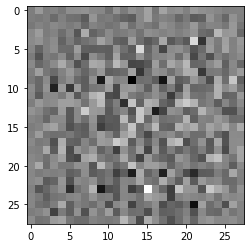

In [ ]:
generator = make_generator_model(generator_input_dim)

noise = tf.random.normal([1, generator_input_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [ ]:
def make_discriminator_model(input_channels):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, input_channels]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model(discriminator_im_chan)
#decision = discriminator(generated_image)
#print (decision)

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [ ]:
EPOCHS = 50

num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, z_dim])
lab = []
for i in range(num_examples_to_generate):
  onehotlabel = tf.constant([0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
  lab.append(onehotlabel)

ohlab = tf.stack(lab)
print(ohlab)
onehotlabel = tf.reshape(onehotlabel, (1,10))
seed = combine(seed, ohlab)
print(tf.shape(seed))

tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(16, 10), dtype=float32)
tf.Tensor([16 74], shape=(2,), dtype=int32)


In [ ]:
# def channels(image, labels):
#   a = tf.repeat([0,1,0,0,0,0,0,0,0,0], repeats=[784,784,784,784,784,784,784,784,784,784]).numpy()
#   b = tf.reshape(a, [10,28,28])
#   for i in range(10):
#     image = tf.stack(image, b[i])


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


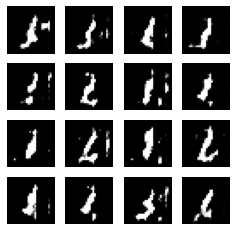

Time for epoch 16 is 326.6072618961334 sec


256it [00:01, 196.81it/s]
256it [00:01, 229.50it/s]
256it [00:01, 221.29it/s]
256it [00:01, 222.49it/s]
256it [00:01, 225.69it/s]
256it [00:01, 222.96it/s]
256it [00:01, 220.14it/s]
256it [00:01, 226.58it/s]
256it [00:01, 221.87it/s]
256it [00:01, 218.79it/s]
256it [00:01, 201.67it/s]
256it [00:01, 216.33it/s]
256it [00:01, 212.24it/s]
256it [00:01, 223.58it/s]
256it [00:01, 220.83it/s]
256it [00:01, 218.58it/s]
256it [00:01, 207.74it/s]
256it [00:01, 224.29it/s]
256it [00:01, 213.82it/s]
256it [00:01, 224.09it/s]
256it [00:01, 207.42it/s]
256it [00:01, 204.71it/s]
256it [00:01, 202.60it/s]
256it [00:01, 226.85it/s]
256it [00:01, 223.92it/s]
256it [00:01, 206.26it/s]
256it [00:01, 223.04it/s]
256it [00:01, 219.16it/s]
256it [00:01, 218.19it/s]
256it [00:01, 231.32it/s]
256it [00:01, 224.25it/s]
256it [00:01, 215.59it/s]
256it [00:01, 219.00it/s]
256it [00:01, 211.86it/s]
256it [00:01, 221.26it/s]
256it [00:01, 221.05it/s]
256it [00:01, 220.74it/s]
256it [00:01, 219.96it/s]
256it [00:01

In [ ]:
#def train(image_dataset, label_dataset, epochs):


for epoch in range(EPOCHS):
  start = time.time()

  for image_batch, label_batch in zip(dataset, label_dataset):
    # train_step(image_batch, label_batch)
    if len(image_batch) == BATCH_SIZE:
      noise = tf.random.normal([BATCH_SIZE, z_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        #image_labels = tf.tile(label_batch, tf.constant([28,28]))
        #image_labels = tf.reshape(image_labels, (256,28,28,10))
        noiseandlabels = combine(noise,label_batch)
        generated_images = generator(noiseandlabels, training=True)
        generated_images = tf.squeeze(generated_images)
        #print(np.shape(generated_images))
        #print(np.shape(label_batch))
        fake_image_and_labels = add_channels(generated_images, label_batch)
        fake_image_and_labels = tf.stack(fake_image_and_labels)

        real_output = discriminator(image_batch, training=True)
        fake_output = discriminator(fake_image_and_labels, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


  # Produce images for the GIF as we go
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                            epoch + 1,
                            seed)

  # Save the model every 15 epochs
  if (epoch + 1) % 15 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

# Generate after the final epoch
display.clear_output(wait=True)
generate_and_save_images(generator,epochs,seed)


In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
  
display_image(EPOCHS)
